## Dublin AirBnb  -  Data analysis project 

Data: 
•	Csv file: ‘lisitngs.csv’. A web-scraped csv file from the Airbnb website from ‘https://insideairbnb.com/get-the-data/’. The data is made up for 75 columns and 4734 rows. It contains information regarding the listing url, name and description of the listing, information about the host such as name, about, location, response time etc.details
•	Host; name, location, date they started hosting, about, if they are a superhost, how many listings they have.
•	Accommodation: Property type, Longitude, latitude,neighbourhood(~50% are blank), neighbourhood_cleansed (4 “neighbourhoods” of Dublin), number of bathrooms, bedrooms, beds, amenities, the price, minimum and maximum number of nights.
•	Reviews: Overall rating, cleanliness, check in, communication, value, location.

•	Geojson file ‘neighbourhoods.geojson’ containing three columns one of which ‘neighbourhood_group’ is blank. The other columns are neighbourhood containing the values “Dublin, City, South Dublin, Fingal, Dn Laoghaire-Rathdown” which aligns with the neighbourhood_cleansed column in the listings file. The last column in geometry which contains the Polygon files for each of the 4 neighbourhoods.


### Load and Clean

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

C:\Users\EoinD\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\EoinD\AppData\Local\Temp\ipykernel_14912\1438236441.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (http

In [60]:
#### Load in the two files
listings = pd.read_csv('listings.csv')
dub_nb =  gpd.read_file('neighbourhoods.geojson')

In [61]:
### Fistly we'll look at the listings information:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4734 entries, 0 to 4733
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4734 non-null   int64  
 1   listing_url                                   4734 non-null   object 
 2   scrape_id                                     4734 non-null   int64  
 3   last_scraped                                  4734 non-null   object 
 4   source                                        4734 non-null   object 
 5   name                                          4734 non-null   object 
 6   description                                   4626 non-null   object 
 7   neighborhood_overview                         2261 non-null   object 
 8   picture_url                                   4734 non-null   object 
 9   host_id                                       4734 non-null   i

The price column is an object as it contains both $ and commas, we want to convert it to a numeric.
The neighbourhood column contains lots of missing values but may be of use later, so to make the merge easier between the listings and the geojson data we'll rename the neighbourhood column to neighbourhood_full and rename neighbourhood_cleansed to neighbourhood. 
We also want to build a geometry column using the longitude and latitude columns.

In [62]:
listings['price'] = listings['price'].str.replace('$','').str.replace(',','')
listings['price'] = pd.to_numeric(listings['price'])
listings.rename(columns = {'neighbourhood': 'full_neighbourhood','neighbourhood_cleansed': 'neighbourhood'}, inplace = True)

# listings['acomd_geometry'] = gpd.GeoDataFrame(
#    listings, geometry = gpd.points_from_xy(x=listings.longitude, y = listings.latitude))

listings.crs = dub_nb.crs

C:\Users\EoinD\AppData\Local\Temp\ipykernel_14912\2726995093.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  listings['price'] = listings['price'].str.replace('$','').str.replace(',','')


In [91]:
listings = listings[listings['price'] != 45880.0]
listings = listings[listings['price'] != 8820.0]

In [93]:
dub_map = listings.merge(dub_nb)

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\EoinD\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\EoinD\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

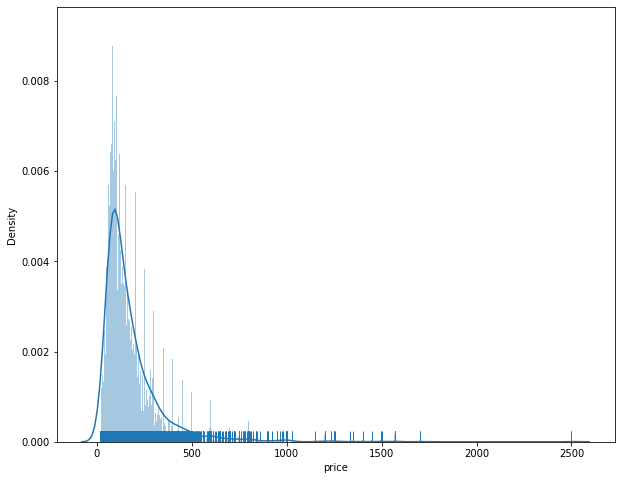

In [94]:
plt.figure(figsize=(10, 8))
x = [1,22,10]
y = [4,56,67]
sns.distplot(dub_map['price'], bins=500, rug=True)

In [78]:
listings['price'].max()

14246.0

In [83]:
listings['price'].nlargest(1000)

4649    14246.0
176      2500.0
1274     2500.0
537      1700.0
1472     1700.0
         ...   
2393      240.0
2830      240.0
3079      240.0
3163      240.0
3280      240.0
Name: price, Length: 1000, dtype: float64